# Attack pipeline on Diva using a Decision Tree as explainer

In [24]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../../")
sys.path.append("../../lime/")
import mlem
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.utils import shuffle
from sklearn import tree
from pathlib import Path

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from mlem.utilities import save_pickle_bz2, load_pickle_bz2

# DATA LOADING AND CONFIGURATION

In [3]:
from mlem.utilities import load_pickle_bz2

data for the attack

In [4]:
BLACK_BOX = load_pickle_bz2("../datasets/diva/BB_NO_CLUSTERING/BB_DATA/diva_rf_noclustering.bz2")
# x_train x_test y_train y_test x_test_clustered y_test_clustered
BLACK_BOX_DATA = np.load("../datasets/diva/BB_NO_CLUSTERING/BB_DATA/diva_rf_noclustering_data_nsamples_5.npz")
# on the version of diva we're using all the features are numeric
CATEGORICAL_FEATURES_MASK = [False for x in BLACK_BOX_DATA['x_train'][0] ]

In [5]:
train_distr = pd.DataFrame(BLACK_BOX_DATA['y_train']).value_counts(normalize=True)
test_distr = pd.DataFrame(BLACK_BOX_DATA['y_test']).value_counts(normalize=True)

In [6]:
print(f"train size = {len(BLACK_BOX_DATA['y_train'])} | test size = {len(BLACK_BOX_DATA['y_test'])} | total size = {len(BLACK_BOX_DATA['y_train']) + len(BLACK_BOX_DATA['y_test'])}")
print(f"train distribution:\n{train_distr}\n")
print(f"test distribution:\n{test_distr}")

train size = 6624 | test size = 2839 | total size = 9463
train distribution:
0    0.737772
1    0.262228
dtype: float64

test distribution:
0    0.737584
1    0.262416
dtype: float64


X and Y are the row to attack

In [7]:
INDEX = 0

In [8]:
X = BLACK_BOX_DATA['x_test_clustered'][INDEX]
Y = BLACK_BOX_DATA['y_test_clustered'][INDEX]

### building the explainer

Training the explainer on the training data of the black box

In [9]:
explainer_training_data = BLACK_BOX_DATA['x_train']
explainer = LimeTabularExplainer(training_data=explainer_training_data, categorical_features=[i for (i, el) in enumerate(CATEGORICAL_FEATURES_MASK) if el], random_state=123)

# Attack Pipeline

## 1) Creating the local explainer

at the end of this section the important variables will be:
* `local_model` : contains the local model (the ensemble classifier generated by LIME)
* `x_neigh` : contains the neighborhood generated by LIME
* `y_neigh`: contains the classification of `x_neigh` generated by the local_model

This code is contained in the `__get_local_data` function in the mlem code

In [10]:
explanations, lime_models, x_neigh = explainer.explain_instance(X, BLACK_BOX.predict_proba, labels=[0,1], sampling_method="gaussian", num_samples=5000, num_features=len(X))

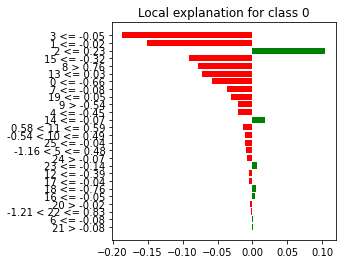

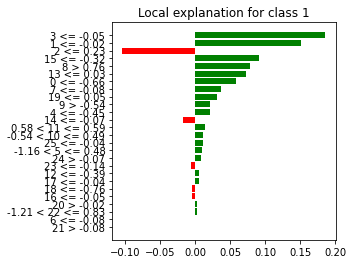

In [11]:
fig0 = explanations.as_pyplot_figure(label=0)
fig1 = explanations.as_pyplot_figure(label=1)

Difference between the points in the neighborhood and the original instance.

*The instances generated by LIME are not very close to the original instance, maybe we could generate neighborhoods in a loop and keep only the closest elements*

In [12]:
from mlem.utilities import norm_nocategorical
difference_from_X_cat = [np.linalg.norm(x_neigh[0]-x) for x in x_neigh]
difference_from_X_nocat = [norm_nocategorical(x_neigh[0]-x, CATEGORICAL_FEATURES_MASK) for x in x_neigh]
print(f"with cat:\tmax = {max(difference_from_X_cat[1:]):.2f} min = {min(difference_from_X_cat[1:]):.2f} avg = {np.average(difference_from_X_cat[1:]):.2f} std= {np.std(difference_from_X_cat[1:]):.2f}")
print(f"without cat:\tmax = {max(difference_from_X_nocat[1:]):.2f} min = {min(difference_from_X_nocat[1:]):.2f} avg = {np.average(difference_from_X_nocat[1:]):.2f} std= {np.std(difference_from_X_nocat[1:]):.2f}")

with cat:	max = 20.66 min = 2.22 avg = 5.80 std= 1.77
without cat:	max = 20.66 min = 2.22 avg = 5.80 std= 1.77


Creating the local model as ensamble of the models returned by lime

In [13]:
attack_dataset = pd.DataFrame(x_neigh)
attack_dataset['Target'] = BLACK_BOX.predict(attack_dataset.to_numpy())

In [14]:
attack_dataset.Target.value_counts()

0    4593
1     407
Name: Target, dtype: int64

In [16]:
def generate_balanced_dataset(x, num_samples, black_box, explainer, max_tries=15, shuffle=True, verbose=False):
    generated = pd.DataFrame(explainer.data_inverse(x, 5000, 'gaussian')[1])
    generated['Target'] = black_box.predict(generated.to_numpy())
    min_class =-np.NINF
    final = pd.DataFrame()
    for t in range(max_tries):
        if verbose:
            print(f"try number {t}")
        
        if len(final) >= num_samples:
            
            return final.sample(frac=1) if shuffle else final
        
        generated = pd.DataFrame(explainer.data_inverse(x, 5000, 'gaussian')[1])
        generated['Target'] = black_box.predict(generated.to_numpy())
        
        zeroes = generated[generated['Target'] == 0]
        ones   = generated[generated['Target'] == 1]
        
        if len(zeroes) == 0 or len(ones) == 0:
            continue
        
        if len(final) < num_samples:
            min_len = min(len(zeroes), len(ones))
            final = pd.concat([final, zeroes.head(min_len).copy(), ones.head(min_len).copy()])
    
        if verbose:
            p0, p1 = final.Target.value_counts(normalize=True)
            print(f"{len(final)=} {p0=} {p1=}")
        
        
    raise Exception("Could not generate balanced dataset")


In [17]:
#g = generate_balanced_dataset(X, 5000, BLACK_BOX, explainer, 20, True, True)

In [18]:
#g.to_csv("diva_lime_generated_around_0.csv", index=False)

In [19]:
generated_dataset = pd.read_csv("diva_lime_generated_around_0.csv")

In [20]:
ATTACK_DATASET = generated_dataset.copy()

In [21]:
ATTACK_DATASET

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,Target
0,1.518260,0.550878,1.293706,-0.049350,-0.000011,0.477425,0.000001,0.518237,1.181681,0.000000,...,1.611936,-0.243428,-2.599611,-0.026422,0.000000,0.828543,0.000000,-0.183626,-0.000001,0
1,-0.000011,1.568210,-0.118767,-0.046192,-0.000011,-1.209081,0.000001,-0.077592,-0.431329,0.000000,...,-0.038690,-1.606713,-1.839627,-0.026466,0.000000,-0.000022,0.000000,-0.173819,-0.000001,0
2,-0.000011,-0.014742,-0.281302,-0.050877,0.087451,0.477425,0.000001,2.254914,1.068677,0.000000,...,1.483184,-0.162077,-0.070226,-0.025789,0.000000,0.828543,0.000000,-0.213082,-0.000001,0
3,-0.000011,-1.967800,2.143356,-0.041324,1.705630,0.477425,2.773158,-0.068958,1.621821,0.000000,...,-0.038045,0.401027,0.164120,1.276285,0.000000,0.828543,0.000000,-0.212144,-0.000001,1
4,-0.000011,-0.016111,-0.582155,-0.053722,1.069255,-1.264098,1.370225,-0.067236,0.630806,0.000000,...,3.441708,-1.564372,-1.563356,-0.026162,1.863259,0.828543,4.304803,1.382796,-0.000001,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5549,-0.000011,3.569423,-1.094050,-0.050422,-0.000011,-1.273831,0.000001,2.340201,0.557249,1.843203,...,-0.036670,1.727552,0.561783,-0.026285,0.000000,-0.000022,0.000000,-0.207784,-0.000001,0
5550,-0.000011,-0.018097,-0.089324,6.996741,-0.000011,-1.178179,0.000001,-0.075297,-1.967313,0.000000,...,-0.036215,-0.197825,0.237145,-0.026153,0.372477,0.828543,4.082327,-0.209003,-0.000001,0
5551,-0.000011,-1.601152,-0.204583,-0.052233,-0.000011,0.477425,3.688038,5.765174,0.669428,0.000000,...,-0.037867,0.132109,0.231229,-0.026406,2.700393,0.828543,0.000000,-0.169674,-0.000001,1
5552,-0.000011,-3.729074,0.163044,-0.052548,-0.000011,0.477425,0.000001,-0.086144,-0.100130,0.000000,...,0.558164,0.384359,0.164071,2.033551,4.513393,0.828543,0.000000,-0.144984,-0.000001,1


In [22]:
# Hyperparameters of the grid search
__HYPERPARAMETERS = {
    "criterion": ["gini", "entropy"],
}

def create_decision_tree(
        x_train,
        y_train,
        hyperparameters = __HYPERPARAMETERS,
        n_jobs=4,
        use_halving=True
):
    """Creates a random forest classifier via grid search.

    Args:
        x_train (ndarray): Training input examples.
        y_train (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search. (default 4)
        use_halving (bool): If true use the HalvingGridSearch

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    dt = tree.DecisionTreeClassifier()

    if use_halving:
        clf = HalvingGridSearchCV(dt, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    else:
        clf = RandomizedSearchCV(dt, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    clf.fit(x_train, y_train)
    # print(f"GRID_SEARCH BEST PARAMS: {clf.best_params_=}")
    return clf.best_estimator_

In [23]:
X_train, X_test, y_train, y_test = train_test_split(generated_dataset.drop('Target', axis=1).to_numpy(), generated_dataset.Target.to_numpy(), test_size=0.33, random_state=42)

In [25]:
dt = create_decision_tree(X_train, y_train, use_halving=True) if not Path("decision_tree_diva_91.bz2").exists() else load_pickle_bz2("decision_tree_diva_91.bz2")

In [26]:
dt

DecisionTreeClassifier(criterion='entropy')

The decision tree has good performances

In [27]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       903
           1       0.91      0.90      0.91       930

    accuracy                           0.91      1833
   macro avg       0.91      0.91      0.91      1833
weighted avg       0.91      0.91      0.91      1833



In [28]:
if not Path("decision_tree_diva_91.bz2").exists():
    save_pickle_bz2("decision_tree_diva_91.bz2", dt)
    np.savez("decision_tree_diva_91.data.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Attacking the decision tree

In [29]:
from mlem.shadow_models import ShadowModelsManager

In [30]:
local_tree = load_pickle_bz2("decision_tree_diva_91.bz2")
loaded     = np.load("decision_tree_diva_91.data.npz", allow_pickle=True)

In [31]:
X_train = loaded['X_train']
X_test  = loaded['X_test']
y_train = loaded['y_train']
y_test  = loaded['y_test']
full_generated_dataset = pd.read_csv("diva_lime_generated_around_0.csv")

### with Adaboost

Using the lime generated dataset as x_attack and the labels computed by the dt as y_attack

In [32]:
x_attack = full_generated_dataset.drop('Target', axis=1)
y_attack = local_tree.predict(x_attack.to_numpy())

In [33]:
(y_attack == full_generated_dataset.Target).value_counts(normalize=True)

True     0.969031
False    0.030969
Name: Target, dtype: float64

In [34]:
from mlem.utilities import create_adaboost

path="DT/shadow_adab_diva_dt"

shadow_models = ShadowModelsManager(
        n_models=4,
        results_path=f"{path}/shadow",
        test_size=0.5,
        random_state=123,
        model_creator_fn=create_adaboost,
        categorical_mask=CATEGORICAL_FEATURES_MASK
    )

Fitting 4 shadow models on the data

In [35]:
shadow_models.fit(x_attack, y_attack)

In [36]:
attack_dataset = shadow_models.get_attack_dataset()
attack_dataset

,0,1,label,inout
0,0.563805,0.436195,0,in
1,0.485004,0.514996,1,in
2,0.551580,0.448420,0,in
3,0.483428,0.516572,0,in
4,0.510733,0.489267,0,in
...,...,...,...,...
2772,0.489500,0.510500,1,out
2773,0.489806,0.510194,1,out
2774,0.538005,0.461995,0,out
2775,0.549349,0.450651,0,out


The mean and std are close to 0.5 and 0

In [42]:
attack_dataset[attack_dataset.label == 0][[0,1]].describe()

,0,1
count,11140.000000,11140.000000
mean,0.528280,0.471720
std,0.020635,0.020635
min,0.467184,0.413332
25%,0.512528,0.456202
50%,0.528292,0.471708
75%,0.543798,0.487472
max,0.586668,0.532816


In [43]:
attack_dataset[attack_dataset.label == 1][[0,1]].describe()

,0,1
count,11108.000000,11108.000000
mean,0.481154,0.518846
std,0.012986,0.012986
min,0.415295,0.468298
25%,0.473045,0.510119
50%,0.481750,0.518250
75%,0.489881,0.526955
max,0.531702,0.584705


Creating the attack models, one for each label

In [44]:
from mlem.attack_models import AttackModelsManager, AttackStrategy
attack_models = AttackModelsManager(
        results_path=f"DT/attack_adab_diva_dt", model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
)

In [45]:
attack_models.fit(attack_dataset)

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling


In [46]:
atk_0 = load_pickle_bz2("DT/attack_adab_diva_dt/0/model.pkl.bz2")
atk_1 = load_pickle_bz2("DT/attack_adab_diva_dt/1/model.pkl.bz2")

## Attack on the whole datasets of the BB

In [47]:
BB_TRAIN = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_TRAIN['Target'] = BLACK_BOX_DATA['y_train']

BB_TEST = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_TEST['Target'] = BLACK_BOX_DATA['y_test']

In [48]:
BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]

In [49]:
BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))

In [50]:
BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())

In [51]:
BB_TEST_0['Y'] = 'out'
BB_TEST_1['Y'] = 'out'
BB_TRAIN_0['Y'] = 'in'
BB_TRAIN_1['Y'] = 'in'

In [52]:
BB_TRAIN_0

,0,1,ATK,Y
0,0.998121,0.001879,in,in
1,0.979405,0.020595,in,in
2,0.977480,0.022520,in,in
3,0.791864,0.208136,in,in
4,0.998667,0.001333,in,in
...,...,...,...,...
4882,0.819069,0.180931,in,in
4883,1.000000,0.000000,in,in
4884,0.969280,0.030720,in,in
4885,0.741606,0.258394,in,in


In [53]:
train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])

In [54]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.71      0.73      0.72      6624
         out       0.32      0.29      0.30      2839

    accuracy                           0.60      9463
   macro avg       0.51      0.51      0.51      9463
weighted avg       0.59      0.60      0.59      9463



In [57]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     2021
out     818
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f36dc93bd00>


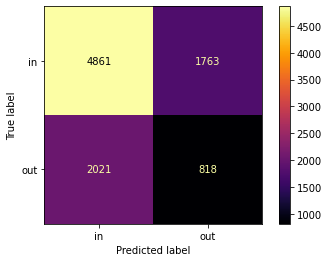

In [59]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

Let's see on the points closest to the instance used to create the neighborhood

In [61]:
import scipy.spatial.distance as distance

In [66]:
BB_DATA_TR = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_DATA_TR['Target'] = BLACK_BOX_DATA['y_train']
BB_DATA_TR['Distance'] = distance.cdist(BLACK_BOX_DATA['x_train'], [X], metric="euclidean")

BB_DATA_TE = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_DATA_TE['Target'] = BLACK_BOX_DATA['y_test']
BB_DATA_TE['Distance'] = distance.cdist(BLACK_BOX_DATA['x_test'], [X], metric="euclidean")

In [68]:
BB_DATA_TR.Distance.describe()

count    6624.000000
mean        4.487911
std         4.081426
min         0.181771
25%         3.329167
50%         4.255069
75%         5.112993
max       124.664422
Name: Distance, dtype: float64

In [69]:
BB_DATA_TE.Distance.describe()

count    2839.000000
mean        4.443655
std         3.768543
min         0.000000
25%         3.352572
50%         4.233015
75%         5.119664
max       108.097071
Name: Distance, dtype: float64

In [75]:
BB_DATA_TR[BB_DATA_TR.Distance < 2.5].Target.value_counts(normalize=True)

1    0.569307
0    0.430693
Name: Target, dtype: float64

In [80]:
BB_DATA_TE[BB_DATA_TE.Distance < 3].Target.value_counts(normalize=True)

1    0.553571
0    0.446429
Name: Target, dtype: float64

Creating the dataset with the closest points

In [83]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 2.5].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 3].drop('Distance', axis=1)

In [84]:
BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]

In [85]:
BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))

In [86]:
BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())

In [87]:
BB_TEST_0['Y'] = 'out'
BB_TEST_1['Y'] = 'out'
BB_TRAIN_0['Y'] = 'in'
BB_TRAIN_1['Y'] = 'in'

In [89]:
train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])

In [90]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.55      0.41      0.47       606
         out       0.46      0.60      0.52       504

    accuracy                           0.50      1110
   macro avg       0.51      0.51      0.50      1110
weighted avg       0.51      0.50      0.50      1110



In [91]:
train_test[train_test.Y == 'out'].ATK.value_counts()

out    302
in     202
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f3586973d60>


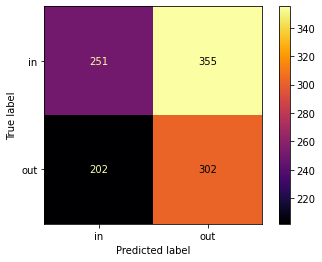

In [92]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

Creating dataset with points closer that 1

In [104]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 1].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 1].drop('Distance', axis=1)

In [105]:
BB_TRAIN

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,Target
146,-0.658649,-0.064574,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.761774,-0.056176,-0.005462,-0.071749,0.828543,-0.139304,-0.150759,-0.035737,1
196,-0.658649,-0.022372,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.761774,0.165868,-0.023915,-0.075926,0.828543,-0.139304,-0.176602,-0.035737,1
276,-0.658649,-0.021866,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.991929,0.168030,-0.024119,-0.075926,0.828543,-0.139304,-0.180072,-0.035737,1
334,-0.658649,-0.087144,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.783542,1.843203,...,-0.036045,-1.452239,-0.110743,0.004377,-0.075926,0.828543,-0.139304,-0.213764,-0.035737,1
491,-0.658649,-0.154596,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.301464,-0.566196,0.033478,-0.075926,0.828543,-0.139304,0.411437,-0.035737,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6247,-0.658649,-0.024889,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.991929,0.155113,-0.022794,-0.075926,0.828543,-0.139304,-0.159341,-0.035737,1
6396,-0.658649,-0.103707,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.761774,-0.181832,-0.026168,-0.075926,0.828543,-0.139304,0.092846,-0.035737,1
6466,-0.658649,-0.003208,0.228899,-0.047288,-0.449675,0.477425,-0.082859,-0.077551,0.703480,1.843203,...,-0.036188,-0.301464,0.174865,-0.026241,-0.075926,0.828543,-0.139304,-0.191041,-0.035737,0
6493,-0.658649,-0.022323,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.761774,0.166079,-0.023915,-0.075926,0.828543,-0.139304,-0.176941,-0.035737,1


In [106]:
BB_TEST

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,Target
45,-0.658649,-0.064107,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.779636,1.843203,...,-0.036188,-0.761774,-0.028698,-0.009250,-0.075713,0.828543,-0.139304,-0.078350,-0.035737,1
202,-0.658649,-0.010781,0.228899,-0.043629,-0.449675,0.477425,-0.082859,-0.077551,0.475011,1.843203,...,-0.036188,-0.301464,0.072369,-0.025692,-0.075926,0.828543,-0.139304,-0.026545,-0.035737,0
219,-0.658649,-0.024189,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.761774,0.158104,-0.023100,-0.075926,0.828543,-0.139304,-0.164141,-0.035737,1
550,-0.658649,0.001028,0.228899,-0.048639,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.071309,0.188486,-0.026333,-0.075926,0.828543,-0.139304,-0.212901,-0.035737,0
646,-0.658649,0.023285,0.228899,-0.040507,-0.449675,0.477425,-0.082859,-0.039786,0.697622,1.843203,...,-0.036188,-0.301464,0.105826,-0.025843,-0.014271,0.828543,-0.139304,-0.080235,-0.035737,0
647,-0.658649,-0.023256,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.991929,0.162092,-0.023507,-0.075926,0.828543,-0.139304,-0.170541,-0.035737,1
741,-0.658649,0.047466,0.228899,-0.032709,-0.449675,0.477425,-0.082859,-0.077551,0.689811,1.843203,...,-0.036179,-0.761774,0.111865,-0.025633,-0.075926,0.828543,-0.139304,-0.089932,-0.035737,0
766,-0.658649,-0.110173,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077439,0.785494,1.843203,...,-0.036188,-0.761774,-0.205069,0.014391,-0.075926,0.828543,-0.139304,0.425596,-0.035737,1
960,-0.658649,-0.051298,0.228899,-0.054624,-0.449675,0.477425,-0.082859,-0.077551,0.785494,1.843203,...,-0.036188,-0.301464,0.022252,-0.026360,-0.075926,0.828543,-0.139304,-0.076315,-0.035737,1
978,-0.658649,0.006718,0.228899,-0.042931,-0.449675,0.477425,-0.082859,-0.077551,0.713244,1.843203,...,-0.035699,-0.991929,0.150021,-0.026228,-0.054237,0.828543,-0.139304,-0.151169,-0.035737,0


In [107]:
BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]

In [108]:
BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))

In [109]:
BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())

In [110]:
BB_TEST_0['Y'] = 'out'
BB_TEST_1['Y'] = 'out'
BB_TRAIN_0['Y'] = 'in'
BB_TRAIN_1['Y'] = 'in'

In [111]:
train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])

In [112]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.70      0.25      0.37        85
         out       0.26      0.72      0.39        32

    accuracy                           0.38       117
   macro avg       0.48      0.48      0.38       117
weighted avg       0.58      0.38      0.37       117



In [113]:
train_test[train_test.Y == 'out'].ATK.value_counts()

out    23
in      9
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f36ba9c4df0>


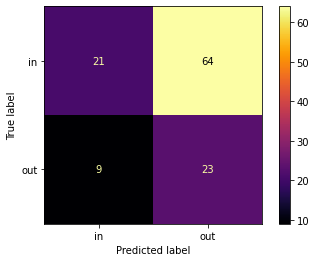

In [114]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')